In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import pickle as pkl
import os
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


In [2]:
# Base directory
base_dir = "./runs"

# Initialize the dictionary to store results
results_dict = {}

# Loop through each subdirectory in the base directory
for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    
    # Ensure it's a directory and matches the "leaf_" pattern
    if os.path.isdir(sub_dir_path) and sub_dir.startswith("leaf_"):
        try:
            # Extract the numeric index after "leaf_"
            index = int(sub_dir.split("_")[1])
            
            # Path to the pickle file
            pickle_file = os.path.join(sub_dir_path, "test/model_epoch020/test_results.p")
            
            # Check if the pickle file exists
            if os.path.exists(pickle_file):
                # Load the pickle file
                with open(pickle_file, "rb") as f:
                    results = pkl.load(f)
                
                # Store the results in the dictionary
                results_dict[index] = results
                print(f"Loaded results for index {index} from {pickle_file}")
            else:
                print(f"Pickle file not found for {sub_dir}")
        
        except (IndexError, ValueError) as e:
            print(f"Error processing directory {sub_dir}: {e}")

# Print summary of loaded results
print(f"\nLoaded results for {len(results_dict)} runs.")

Loaded results for index 1172 from ./runs/leaf_1172_0401_195130/test/model_epoch020/test_results.p
Loaded results for index 1021 from ./runs/leaf_1021_0401_191112/test/model_epoch020/test_results.p
Loaded results for index 1046 from ./runs/leaf_1046_0401_191734/test/model_epoch020/test_results.p
Loaded results for index 1150 from ./runs/leaf_1150_0401_194550/test/model_epoch020/test_results.p
Loaded results for index 1057 from ./runs/leaf_1057_0401_192022/test/model_epoch020/test_results.p
Loaded results for index 1153 from ./runs/leaf_1153_0401_194637/test/model_epoch020/test_results.p
Loaded results for index 1011 from ./runs/leaf_1011_0401_190840/test/model_epoch020/test_results.p
Loaded results for index 1001 from ./runs/leaf_1001_0401_190610/test/model_epoch020/test_results.p
Loaded results for index 1102 from ./runs/leaf_1102_0401_193250/test/model_epoch020/test_results.p
Loaded results for index 1010 from ./runs/leaf_1010_0401_190825/test/model_epoch020/test_results.p
Loaded res

In [3]:
run_ids = list(results_dict.keys())

In [4]:
results_dict[run_ids[0]]

{'02472000': {'1D': {'xr': <xarray.Dataset>
   Dimensions:         (date: 12418, time_step: 1)
   Coordinates:
     * date            (date) datetime64[ns] 1980-10-01 1980-10-02 ... 2014-09-30
     * time_step       (time_step) int64 0
   Data variables:
       QObs(mm/d)_obs  (date, time_step) float32 0.3421 0.2849 ... 0.187 0.1793
       QObs(mm/d)_sim  (date, time_step) float32 nan nan nan nan ... nan nan nan,
   'FDC-Divergence': 0.21354970335960388,
   'KGE': 0.7052784835784278}}}

In [5]:
# plt.figure(figsize=(6, 5))
# for i, run_id in enumerate(run_ids):
#     results = results_dict[run_id]
#     for key, value in results.items():  # Navigate the nested dictionary structure
#         if '1D' in value:
#             ds = value['1D']['xr']  # Extract the xarray Dataset
#             if i == 0:
#                 obs_values = ds['QObs(mm/d)_obs'].values.flatten()  # Observed values (from the last run ID)
#                 plt.plot(dates, obs_values, color="black", linewidth=2, label="Observed")
#             sim_values = ds['QObs(mm/d)_sim'].values.flatten()  # Simulated values
#             dates = ds['date'].values  # Dates
#             plt.plot(dates, sim_values, color="lightgrey", linewidth=0.5, label="Simulated (Example)" if run_id == run_ids[0] else None)
# plt.legend()
# plt.xlabel("Date")
# plt.ylabel("QObs (mm/d)")
# plt.title("Observed vs Simulated Time Series")
# plt.tight_layout()
# plt.show()

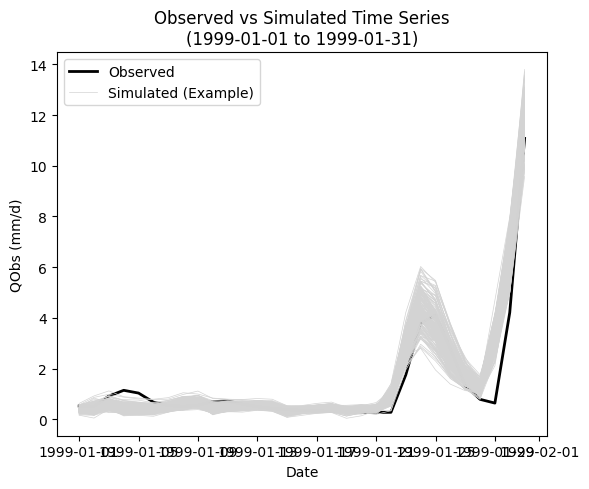

In [6]:
plot_start = "1999-01-01"
plot_end = "1999-01-31"
plot_start_date = np.datetime64(plot_start)
plot_end_date = np.datetime64(plot_end)
plt.figure(figsize=(6, 5))
for i, run_id in enumerate(run_ids):
    results = results_dict[run_id]
    for key, value in results.items():  # Navigate the nested dictionary structure
        if '1D' in value:
            ds = value['1D']['xr']  # Extract the xarray Dataset
            dates = ds['date'].values  # Dates
            date_mask = (dates >= plot_start_date) & (dates <= plot_end_date)
            filtered_dates = dates[date_mask]
            if i == 0:  # Plot observed only once
                obs_values = ds['QObs(mm/d)_obs'].values.flatten()[date_mask]  # Observed values
                plt.plot(filtered_dates, obs_values, color="black", linewidth=2, label="Observed")            
            sim_values = ds['QObs(mm/d)_sim'].values.flatten()[date_mask]  # Simulated values
            plt.plot(filtered_dates, sim_values, color="lightgrey", linewidth=0.5, label="Simulated (Example)" if run_id == run_ids[0] else None)
plt.legend()
plt.xlabel("Date")
plt.ylabel("QObs (mm/d)")
plt.title(f"Observed vs Simulated Time Series\n({plot_start} to {plot_end})")
plt.tight_layout()
plt.show()


In [7]:
def compute_fdc_divergence(obs, sim):
    """Compute FDC divergence between observed and simulated values."""
    # Mask NaN values
    mask = ~np.isnan(obs) & ~np.isnan(sim)
    obs = obs[mask]
    sim = sim[mask]

    # Sort in descending order to construct FDCs
    obs_sorted = np.sort(obs)[::-1]
    sim_sorted = np.sort(sim)[::-1]

    # Ensure both FDCs have the same length
    min_len = min(len(obs_sorted), len(sim_sorted))
    obs_sorted = obs_sorted[:min_len]
    sim_sorted = sim_sorted[:min_len]

    # Compute cross-distribution variability
    cross_variability = np.abs(obs_sorted[:, None] - sim_sorted[None, :]).mean()

    # Compute within-distribution variability
    within_variability_obs = np.abs(obs_sorted[:, None] - obs_sorted[None, :]).mean()
    within_variability_sim = np.abs(sim_sorted[:, None] - sim_sorted[None, :]).mean()

    # Compute FDC divergence
    fdc_divergence = cross_variability - 0.5 * (within_variability_obs + within_variability_sim)

    return max(fdc_divergence, 0.0)  # Ensure non-negative divergence

In [8]:
# Define FDC and plot date ranges
fdc_start_date = "1990-01-01"
fdc_end_date = "1995-12-31"
plot_start_date = "1997-12-15"
plot_end_date = "1998-01-15"

# Convert to datetime objects for filtering
fdc_start_date = np.datetime64(fdc_start_date)
fdc_end_date = np.datetime64(fdc_end_date)
plot_start_date = np.datetime64(plot_start_date)
plot_end_date = np.datetime64(plot_end_date)

# Initialize lists to store divergences and corresponding data
fdc_divergences = []
simulations = []

for run_id in run_ids:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            dates = ds['date'].values

            # Filter dates for FDC divergence calculation
            fdc_mask = (dates >= fdc_start_date) & (dates <= fdc_end_date)
            obs = ds['QObs(mm/d)_obs'].values.flatten()[fdc_mask]
            sim = ds['QObs(mm/d)_sim'].values.flatten()[fdc_mask]

            # Compute FDC divergence within the specified range
            fdc_divergence = compute_fdc_divergence(obs, sim)
            fdc_divergences.append(fdc_divergence)

            # Filter dates for plotting
            plot_mask = (dates >= plot_start_date) & (dates <= plot_end_date)
            filtered_dates = dates[plot_mask]
            filtered_sim = ds['QObs(mm/d)_sim'].values.flatten()[plot_mask]

            # Store dates and filtered simulation for plotting
            simulations.append((filtered_dates, filtered_sim))

# Sort simulations by FDC divergence
sorted_indices = np.argsort(fdc_divergences)
sorted_divergences = [fdc_divergences[i] for i in sorted_indices]
sorted_simulations = [simulations[i] for i in sorted_indices]


/tmp/ipykernel_29088/4204940209.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


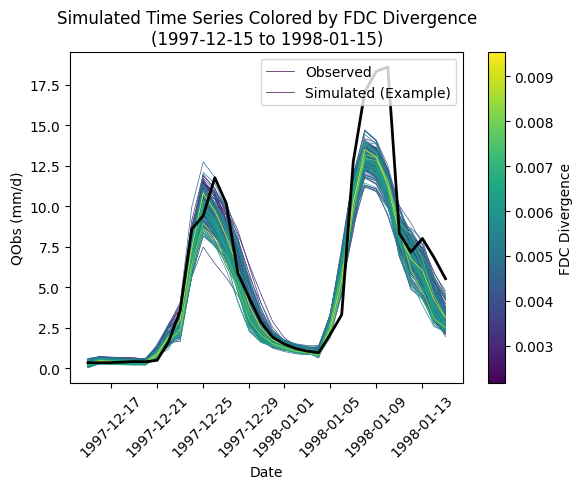

In [9]:
# Plot with color scale
plt.figure(figsize=(6, 5))
norm = Normalize(vmin=min(sorted_divergences), vmax=max(sorted_divergences))
cmap = plt.get_cmap('viridis')

for i, (dates, sim) in enumerate(sorted_simulations):
    color = cmap(norm(sorted_divergences[i]))
    plt.plot(dates, sim, color=color, linewidth=0.5)

# Plot observed values on top
obs_plot_mask = (ds['date'].values >= plot_start_date) & (ds['date'].values <= plot_end_date)
obs_filtered = ds['QObs(mm/d)_obs'].values[obs_plot_mask].flatten()  # Apply mask before flattening
filtered_dates = ds['date'].values[obs_plot_mask]  # Apply mask to dates

plt.plot(filtered_dates, obs_filtered, color='black', linewidth=2, label='Observed')


# Add colorbar for FDC divergence
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('FDC Divergence')

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("QObs (mm/d)")
plt.title(f"Simulated Time Series Colored by FDC Divergence\n({plot_start_date} to {plot_end_date})")
plt.legend(['Observed', 'Simulated (Example)'], loc='upper right')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

In [10]:
def kge(obs: np.ndarray, sim: np.ndarray, weights: list = [1., 1., 1.]) -> float:
    """
    Calculate the Kling-Gupta Efficiency (KGE).

    Parameters
    ----------
    obs : np.ndarray
        Observed time series.
    sim : np.ndarray
        Simulated time series.
    weights : list
        Weighting factors of the 3 KGE parts, default is equal weights [1, 1, 1].

    Returns
    -------
    float
        Kling-Gupta Efficiency
    """
    if len(weights) != 3:
        raise ValueError("Weights of the KGE must be a list of three values")

    # Mask NaN values
    mask = ~np.isnan(obs) & ~np.isnan(sim)
    obs = obs[mask]
    sim = sim[mask]

    if len(obs) < 2:
        return np.nan

    # Correlation coefficient (r)
    r, _ = stats.pearsonr(obs, sim)

    # Alpha (ratio of standard deviations)
    alpha = np.std(sim) / np.std(obs)

    # Beta (ratio of means)
    beta = np.mean(sim) / np.mean(obs)

    # Compute KGE
    value = (weights[0] * (r - 1)**2 +
             weights[1] * (alpha - 1)**2 +
             weights[2] * (beta - 1)**2)

    return 1 - np.sqrt(float(value))

/tmp/ipykernel_29088/942271420.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


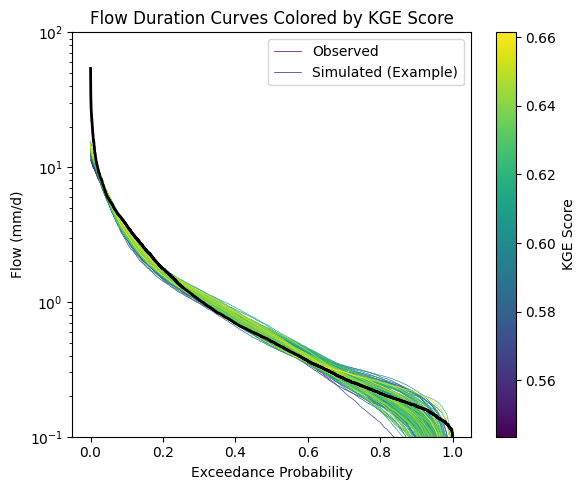

In [11]:
# Define KGE and plot date ranges
kge_start_date = "1990-01-01"
kge_end_date = "1995-12-31"
plot_start_date = "1980-12-15"
plot_end_date = "1998-01-15"

# Convert dates to numpy datetime64
kge_start_date = np.datetime64(kge_start_date)
kge_end_date = np.datetime64(kge_end_date)
plot_start_date = np.datetime64(plot_start_date)
plot_end_date = np.datetime64(plot_end_date)

# Initialize lists to store KGE scores and FDC data
kge_scores = []
fdc_data = []

for run_id in run_ids:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            dates = ds['date'].values

            # Filter dates for KGE calculation
            kge_mask = (dates >= kge_start_date) & (dates <= kge_end_date)
            obs_kge = ds['QObs(mm/d)_obs'].values.flatten()[kge_mask]
            sim_kge = ds['QObs(mm/d)_sim'].values.flatten()[kge_mask]

            # Calculate KGE and store the score
            kge_score = kge(obs_kge, sim_kge)
            kge_scores.append(kge_score)

            # Filter dates for FDC plot
            plot_mask = (dates >= plot_start_date) & (dates <= plot_end_date)
            obs_plot = ds['QObs(mm/d)_obs'].values.flatten()[plot_mask]
            sim_plot = ds['QObs(mm/d)_sim'].values.flatten()[plot_mask]

            # Compute FDCs by sorting in descending order
            obs_fdc = np.sort(obs_plot[~np.isnan(obs_plot)])[::-1]
            sim_fdc = np.sort(sim_plot[~np.isnan(sim_plot)])[::-1]

            # Store FDC data (observed and simulated)
            fdc_data.append((obs_fdc, sim_fdc))

# Sort FDC data by KGE scores
sorted_indices = np.argsort(kge_scores)
sorted_kge_scores = [kge_scores[i] for i in sorted_indices]
sorted_fdc_data = [fdc_data[i] for i in sorted_indices]

# Plot FDCs with color scale based on KGE
plt.figure(figsize=(6, 5))
norm = Normalize(vmin=min(sorted_kge_scores), vmax=max(sorted_kge_scores))
cmap = plt.get_cmap('viridis')

for i, (obs_fdc, sim_fdc) in enumerate(sorted_fdc_data):
    color = cmap(norm(sorted_kge_scores[i]))
    plt.plot(np.arange(1, len(sim_fdc) + 1) / len(sim_fdc), sim_fdc, color=color, linewidth=0.5)

# Plot observed FDC on top
plt.plot(np.arange(1, len(obs_fdc) + 1) / len(obs_fdc), obs_fdc, color='black', linewidth=2, label='Observed')

# Add colorbar for KGE scores
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('KGE Score')
plt.ylim([0.1,100])
plt.yscale('log')
plt.xlabel("Exceedance Probability")
plt.ylabel("Flow (mm/d)")
plt.title("Flow Duration Curves Colored by KGE Score")
plt.legend(['Observed', 'Simulated (Example)'], loc='upper right')
plt.tight_layout()
plt.show()



In [12]:
# Define periods
fdc_model_selection_start_date = "1999-10-01"
fdc_model_selection_end_date = "2008-09-30"
evaluation_start_date = "1980-10-01"
evaluation_end_date = "1989-09-30"

In [13]:
# Convert date strings to numpy datetime64
fdc_selection_start = np.datetime64(fdc_model_selection_start_date)
fdc_selection_end = np.datetime64(fdc_model_selection_end_date)

# Initialize a dictionary to store FDC divergence values
fdc_divergences = {}

for run_id in run_ids:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            dates = ds['date'].values

            # Filter data for the FDC model selection period
            fdc_mask = (dates >= fdc_selection_start) & (dates <= fdc_selection_end)
            obs_fdc = ds['QObs(mm/d)_obs'].values.flatten()[fdc_mask]
            sim_fdc = ds['QObs(mm/d)_sim'].values.flatten()[fdc_mask]

            # Calculate FDC divergence
            divergence = compute_fdc_divergence(obs_fdc, sim_fdc)
            fdc_divergences[run_id] = divergence


In [14]:
# Set the number of models to average for top and bottom
n = 5

# Sort fdc_divergences by divergence scores (ascending)
sorted_runs = sorted(fdc_divergences.items(), key=lambda x: x[1])

# Extract the run_ids for top n, bottom n, and all runs
top_n_runs = [run[0] for run in sorted_runs[:n]]
bottom_n_runs = [run[0] for run in sorted_runs[-n:]]
all_runs = [run[0] for run in sorted_runs]

# Initialize lists to store time series
all_streamflows = []
top_n_streamflows = []
bottom_n_streamflows = []

# Loop through runs and collect simulated time series
for run_id in all_runs:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            sim_values = ds['QObs(mm/d)_sim'].values.flatten()
            all_streamflows.append(sim_values)
            if run_id in top_n_runs:
                top_n_streamflows.append(sim_values)
            if run_id in bottom_n_runs:
                bottom_n_streamflows.append(sim_values)

# Calculate model-averaged time series
null_avg_streamflow = np.nanmean(all_streamflows, axis=0)  # Average of all runs
top_n_avg_streamflow = np.nanmean(top_n_streamflows, axis=0)  # Average of top n runs
bottom_n_avg_streamflow = np.nanmean(bottom_n_streamflows, axis=0)  # Average of bottom n runs

print("Model-averaged time series calculated:")
print(f"  Null (all runs): {len(null_avg_streamflow)} values")
print(f"  Top {n} runs: {len(top_n_avg_streamflow)} values")
print(f"  Bottom {n} runs: {len(bottom_n_avg_streamflow)} values")

Model-averaged time series calculated:
  Null (all runs): 12418 values
  Top 5 runs: 12418 values
  Bottom 5 runs: 12418 values


/tmp/ipykernel_29088/1658880320.py:31: RuntimeWarning: Mean of empty slice
  null_avg_streamflow = np.nanmean(all_streamflows, axis=0)  # Average of all runs
/tmp/ipykernel_29088/1658880320.py:32: RuntimeWarning: Mean of empty slice
  top_n_avg_streamflow = np.nanmean(top_n_streamflows, axis=0)  # Average of top n runs
/tmp/ipykernel_29088/1658880320.py:33: RuntimeWarning: Mean of empty slice
  bottom_n_avg_streamflow = np.nanmean(bottom_n_streamflows, axis=0)  # Average of bottom n runs


In [15]:
# Convert evaluation dates to numpy datetime64
eval_start_date_np = np.datetime64(evaluation_start_date)
eval_end_date_np = np.datetime64(evaluation_end_date)

# Extract observed and simulated values for the test evaluation period
obs_values = None  # Observed values should come from one of the datasets
dates = None  # To store the corresponding dates
for run_id in results_dict:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            dates = ds['date'].values
            obs_values = ds['QObs(mm/d)_obs'].values.flatten()
            break
    if obs_values is not None:
        break

# Ensure observed values and dates are valid
if obs_values is not None and dates is not None:
    # Filter data for the test evaluation period
    eval_mask = (dates >= eval_start_date_np) & (dates <= eval_end_date_np)
    obs_eval = obs_values[eval_mask]
    null_avg_eval = null_avg_streamflow[eval_mask]
    top_n_avg_eval = top_n_avg_streamflow[eval_mask]
    bottom_n_avg_eval = bottom_n_avg_streamflow[eval_mask]

    # Calculate KGE for each model average
    null_kge = kge(obs_eval, null_avg_eval)
    top_n_kge = kge(obs_eval, top_n_avg_eval)
    bottom_n_kge = kge(obs_eval, bottom_n_avg_eval)

    # Calculate FDC divergence for each model average
    null_fdc_divergence = compute_fdc_divergence(obs_eval, null_avg_eval)
    top_n_fdc_divergence = compute_fdc_divergence(obs_eval, top_n_avg_eval)
    bottom_n_fdc_divergence = compute_fdc_divergence(obs_eval, bottom_n_avg_eval)

    # Print results
    print(f"KGE for Null Model (all runs): {null_kge:.3f}")
    print(f"KGE for Top {n} Models: {top_n_kge:.3f}")
    print(f"KGE for Bottom {n} Models: {bottom_n_kge:.3f}")
    print(f"FDC Divergence for Null Model (all runs): {null_fdc_divergence:.3f}")
    print(f"FDC Divergence for Top {n} Models: {top_n_fdc_divergence:.3f}")
    print(f"FDC Divergence for Bottom {n} Models: {bottom_n_fdc_divergence:.3f}")
else:
    print("No valid observed values or dates for the test evaluation period.")



KGE for Null Model (all runs): 0.700
KGE for Top 5 Models: 0.684
KGE for Bottom 5 Models: 0.708
FDC Divergence for Null Model (all runs): 0.003
FDC Divergence for Top 5 Models: 0.004
FDC Divergence for Bottom 5 Models: 0.006


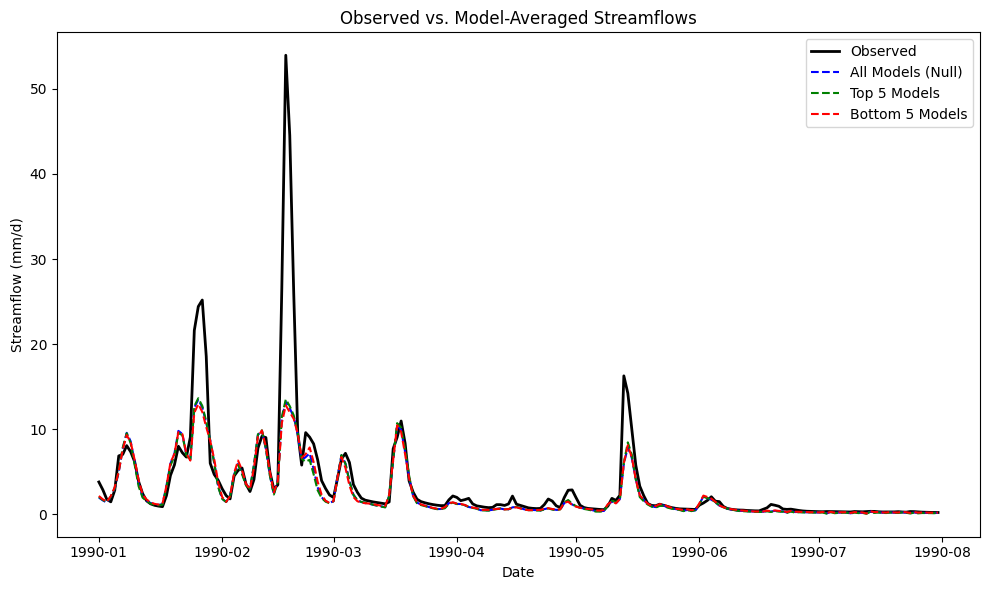

In [16]:
# Define the plot start and end dates
plot_start_date = "1990-01-01"
plot_end_date = "1990-07-31"

# Convert plot start and end dates to numpy datetime64
plot_start = np.datetime64(plot_start_date)
plot_end = np.datetime64(plot_end_date)

# Filter the observed and simulated data for the selected time period
dates = ds['date'].values
plot_mask = (dates >= plot_start) & (dates <= plot_end)

obs_plot = obs_values[plot_mask]  # Observed values
null_avg_plot = null_avg_streamflow[plot_mask]  # Null model average
top_n_avg_plot = top_n_avg_streamflow[plot_mask]  # Top N model average
bottom_n_avg_plot = bottom_n_avg_streamflow[plot_mask]  # Bottom N model average

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(dates[plot_mask], obs_plot, label="Observed", color="black", linewidth=2)
plt.plot(dates[plot_mask], null_avg_plot, label="All Models (Null)", color="blue", linestyle="--")
plt.plot(dates[plot_mask], top_n_avg_plot, label=f"Top {n} Models", color="green", linestyle="--")
plt.plot(dates[plot_mask], bottom_n_avg_plot, label=f"Bottom {n} Models", color="red", linestyle="--")

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Streamflow (mm/d)")
plt.title("Observed vs. Model-Averaged Streamflows")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Prepare data for plotting
# Extract FDC divergence and KGE for each model during both periods
fdc_divergences_eval = []
kge_scores_eval = []
fdc_divergences_selection = []
kge_scores_selection = []

# Loop through runs and calculate metrics
for run_id in run_ids:
    results = results_dict[run_id]
    for key, value in results.items():
        if '1D' in value:
            ds = value['1D']['xr']
            dates = ds['date'].values
            
            # Filter for evaluation period
            eval_mask = (dates >= eval_start_date_np) & (dates <= eval_end_date_np)
            obs_eval = ds['QObs(mm/d)_obs'].values.flatten()[eval_mask]
            sim_eval = ds['QObs(mm/d)_sim'].values.flatten()[eval_mask]
            fdc_divergences_eval.append(compute_fdc_divergence(obs_eval, sim_eval))
            kge_scores_eval.append(kge(obs_eval, sim_eval))
            
            # Filter for model selection period
            selection_mask = (dates >= fdc_selection_start) & (dates <= fdc_selection_end)
            obs_selection = ds['QObs(mm/d)_obs'].values.flatten()[selection_mask]
            sim_selection = ds['QObs(mm/d)_sim'].values.flatten()[selection_mask]
            fdc_divergences_selection.append(compute_fdc_divergence(obs_selection, sim_selection))
            kge_scores_selection.append(kge(obs_selection, sim_selection))

# Identify top and bottom FDC models
sorted_indices = np.argsort(fdc_divergences_selection)
top_indices = sorted_indices[:n]  # Top n models
bottom_indices = sorted_indices[-n:]  # Bottom n models

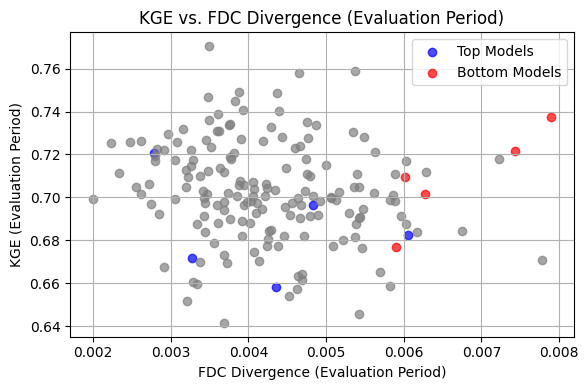

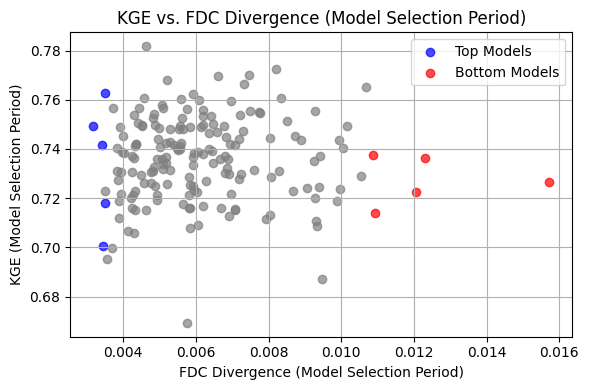

In [18]:
# Plotting the evaluation period scatter plot
plt.figure(figsize=(6, 4))
for i, (fdc, kge) in enumerate(zip(fdc_divergences_eval, kge_scores_eval)):
    color = 'blue' if i in top_indices else 'red' if i in bottom_indices else 'gray'
    plt.scatter(fdc, kge, color=color, label='Top Models' if i == top_indices[0] else 
                'Bottom Models' if i == bottom_indices[0] else None, alpha=0.7)
plt.xlabel("FDC Divergence (Evaluation Period)")
plt.ylabel("KGE (Evaluation Period)")
plt.title("KGE vs. FDC Divergence (Evaluation Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the model selection period scatter plot
plt.figure(figsize=(6, 4))
for i, (fdc, kge) in enumerate(zip(fdc_divergences_selection, kge_scores_selection)):
    color = 'blue' if i in top_indices else 'red' if i in bottom_indices else 'gray'
    plt.scatter(fdc, kge, color=color, label='Top Models' if i == top_indices[0] else 
                'Bottom Models' if i == bottom_indices[0] else None, alpha=0.7)
plt.xlabel("FDC Divergence (Model Selection Period)")
plt.ylabel("KGE (Model Selection Period)")
plt.title("KGE vs. FDC Divergence (Model Selection Period)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

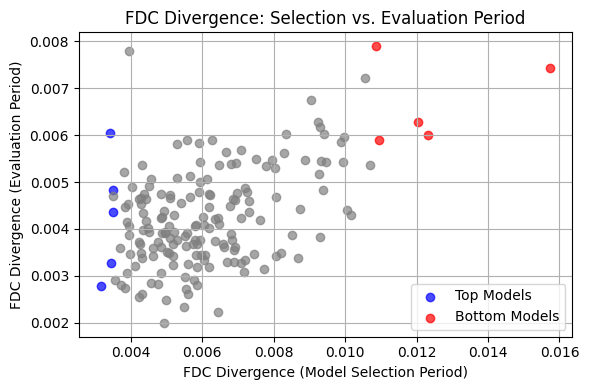

In [19]:
# Plotting the scatter of FDC divergence (Selection vs. Evaluation Period)
plt.figure(figsize=(6, 4))

for i, (fdc_selection, fdc_eval) in enumerate(zip(fdc_divergences_selection, fdc_divergences_eval)):
    color = 'blue' if i in top_indices else 'red' if i in bottom_indices else 'gray'
    plt.scatter(fdc_selection, fdc_eval, color=color, label='Top Models' if i == top_indices[0] else 
                'Bottom Models' if i == bottom_indices[0] else None, alpha=0.7)

# Add labels, title, and legend
plt.xlabel("FDC Divergence (Model Selection Period)")
plt.ylabel("FDC Divergence (Evaluation Period)")
plt.title("FDC Divergence: Selection vs. Evaluation Period")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


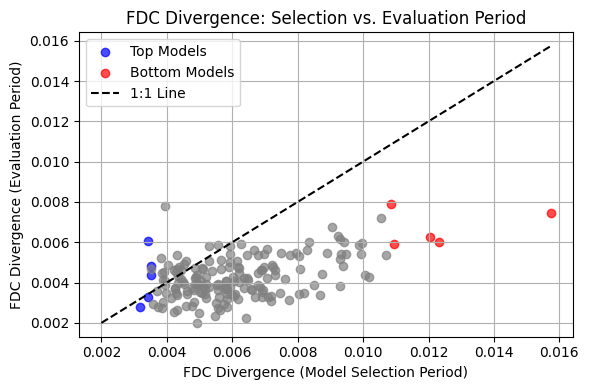

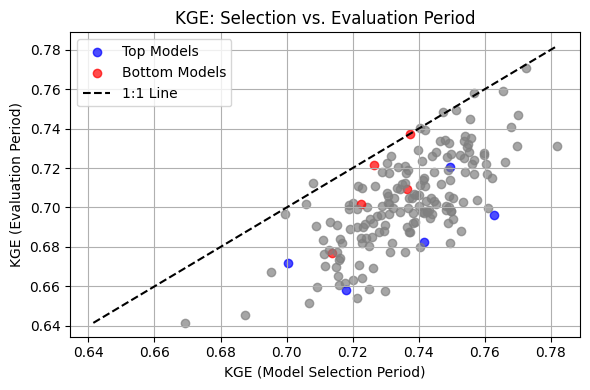

In [21]:
plt.figure(figsize=(6, 4))
# Plot FDC divergence points
for i, (fdc_selection, fdc_eval) in enumerate(zip(fdc_divergences_selection, fdc_divergences_eval)):
    color = 'blue' if i in top_indices else 'red' if i in bottom_indices else 'gray'
    plt.scatter(fdc_selection, fdc_eval, color=color, label='Top Models' if i == top_indices[0] else 
                'Bottom Models' if i == bottom_indices[0] else None, alpha=0.7)

# Add 1:1 line
min_val = min(min(fdc_divergences_selection), min(fdc_divergences_eval))
max_val = max(max(fdc_divergences_selection), max(fdc_divergences_eval))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label="1:1 Line")

# Add labels, title, and legend
plt.xlabel("FDC Divergence (Model Selection Period)")
plt.ylabel("FDC Divergence (Evaluation Period)")
plt.title("FDC Divergence: Selection vs. Evaluation Period")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Plotting the scatter of KGE (Selection vs. Evaluation Period)
plt.figure(figsize=(6, 4))

# Plot KGE points
for i, (kge_selection, kge_eval) in enumerate(zip(kge_scores_selection, kge_scores_eval)):
    color = 'blue' if i in top_indices else 'red' if i in bottom_indices else 'gray'
    plt.scatter(kge_selection, kge_eval, color=color, label='Top Models' if i == top_indices[0] else 
                'Bottom Models' if i == bottom_indices[0] else None, alpha=0.7)

# Add 1:1 line
min_val = min(min(kge_scores_selection), min(kge_scores_eval))
max_val = max(max(kge_scores_selection), max(kge_scores_eval))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label="1:1 Line")

# Add labels, title, and legend
plt.xlabel("KGE (Model Selection Period)")
plt.ylabel("KGE (Evaluation Period)")
plt.title("KGE: Selection vs. Evaluation Period")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()